# Programm zur Erkennung von Hunderassen

## Schritt 1: Daten laden und Aufteilen in Trainings- und Testdaten

In [1]:
# Importieren der notwendigen Bibliotheken
import os
import numpy as np
import xml.etree.ElementTree as ET
from skimage import io, color, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
# Definieren der Pfade zum Datensatz und zu den Annotationen
dataset_path = 'dogs'
annotation_path = 'annotations'


In [3]:
# Funktion zum Parsen der Annotationsdateien
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bndboxes = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        bndboxes.append((xmin, ymin, xmax, ymax))
    return bndboxes


In [4]:
# Laden der Bilder und Extrahieren der Hundebereiche
images = []
labels = []
breeds = os.listdir(dataset_path)

for breed in breeds:
    breed_img_path = os.path.join(dataset_path, breed)
    breed_anno_path = os.path.join(annotation_path, breed)
    if os.path.isdir(breed_img_path):
        for img_name in os.listdir(breed_img_path):
            img_path = os.path.join(breed_img_path, img_name)
            annotation_name = os.path.splitext(img_name)[0]
            annotation_file = os.path.join(breed_anno_path, annotation_name)
            if not os.path.exists(annotation_file):
                continue  # Überspringe Bilder ohne Annotation
            image = io.imread(img_path)
            if image is None:
                continue
            bndboxes = parse_annotation(annotation_file)
            for bndbox in bndboxes:
                xmin, ymin, xmax, ymax = bndbox
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(image.shape[1], xmax)
                ymax = min(image.shape[0], ymax)
                if xmin >= xmax or ymin >= ymax:
                    continue  # Ungültige Bounding Box überspringen
                cropped_image = image[ymin:ymax, xmin:xmax]
                cropped_image = transform.resize(cropped_image, (256, 256))
                images.append(cropped_image)
                labels.append(breed)


In [5]:
# Umwandeln der Labels in numerische Werte
le = LabelEncoder()
y = le.fit_transform(labels)

# Überprüfen, ob Bilder geladen wurden
if len(images) == 0:
	print("Fehler: Keine Bilder geladen. Bitte überprüfen Sie den Pfad und die Annotationsdateien.")
else:
	# Aufteilen in Trainings- und Testdaten
	X_train_img, X_test_img, y_train, y_test = train_test_split(images, y, test_size=0.25, stratify=y, random_state=42)


In [6]:
# Überprüfen der Anzahl der geladenen Bilder
print(f'Anzahl der gesamten Bilder: {len(images)}')
print(f'Anzahl der Trainingsbilder: {len(X_train_img)}')
print(f'Anzahl der Testbilder: {len(X_test_img)}')


Anzahl der gesamten Bilder: 1029
Anzahl der Trainingsbilder: 771
Anzahl der Testbilder: 258


## 2. Schritt: Netzarchitektur festlegen

Convolutional Neural Networks (CNNs) eignen sich hervorragend für Bildklassifikationsaufgaben, da sie räumliche Strukturen in Bildern effektiv erkennen können. CNNs verwenden Faltungsoperationen, die es ihnen ermöglichen, lokale Merkmale wie Kanten, Texturen und Formen zu extrahieren, die für die Unterscheidung von Hunderassen essenziell sind.

**Gründe für die Wahl von CNNs:**

1. Parameterreduzierung: Durch Gewichtsteilung reduzieren CNNs die Anzahl der zu lernenden Parameter im Vergleich zu vollständig verbundenen Netzwerken. Dies ist insbesondere bei großen Eingabebildern (z. B. 256x256) wichtig.
2. Translation Invariance: CNNs können wichtige Merkmale unabhängig von deren Position im Bild erkennen, was bei der Hunderassenerkennung hilfreich ist, da die Hunde in unterschiedlichen Posen und Perspektiven dargestellt sein können.
3. Hierarchisches Lernen: CNNs lernen in den unteren Schichten einfache Merkmale (wie Kanten) und kombinieren diese in höheren Schichten zu komplexeren Merkmalen (z. B. Gesichtszüge von Hunden).

**Netzwerkarchitektur:**
Für die Hunderassenerkennung wähle ich folgende Architektur:

- *Eingabeschicht*: Input-Shape (256, 256, 3) (RGB-Bilder mit Größe 256x256).
- *Faltungsschichten (Convolutional Layers)*: Mehrere Schichten mit 3x3-Filtern und zunehmender Filteranzahl (z. B. 32, 64, 128), um unterschiedliche Merkmale zu extrahieren.
- *Pooling-Schichten (MaxPooling)*: Nach jeder Faltungsschicht zur Reduktion der räumlichen Dimension und zur Verhinderung von Überanpassung.
- *Batch-Normalisierung*: Um die Trainingsstabilität zu erhöhen und den Gradientenfluss zu verbessern.
- *Dropout*: Nach den Faltungsblöcken, um Überanpassung zu reduzieren.
- *Fully-Connected Layer*: Eine oder mehrere vollständig verbundene Schichten, um die gelernte Merkmalsrepräsentation in Klassen zu übersetzen.
- *Ausgabeschicht*: Softmax-Aktivierung mit so vielen Neuronen wie Hunderassenklassen.

## 3. Schritt: Netzarchitektur implementieren

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


# Netzwerkarchitektur
model = Sequential([
    # Faltungsschicht 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Faltungsschicht 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Faltungsschicht 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Übergang zu Fully-Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    # Ausgabeschicht
    Dense(5, activation='softmax')
])

# Netzwerkübersicht anzeigen
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,586,885 (112.87 MB)

 Trainable params: 29,586,437 (112.86 MB)

 Non-trainable params: 448 (1.75 KB)

## 4. Schritt: Wahl einer geeigneten Lossfunktion und eines Optimizers

**Loss-Funktion:** CategoricalCrossentropy
Diese Funktion eignet sich für Multi-Klassen-Klassifikationsprobleme und misst die Divergenz zwischen den vorhergesagten Wahrscheinlichkeiten und den tatsächlichen Klassenlabels.

**Optimizer:** Adam
Der Adam-Optimizer kombiniert die Vorteile von AdaGrad und RMSProp und passt die Lernrate für jeden Parameter dynamisch an. Er ist robust und effizient, besonders bei großen Datenmengen und komplexen Modellen.

In [15]:
# Kompilierung des Modells
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 5. Evaluation mit der Kreuzvalidierung

Fold 1:
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.3371 - loss: 41.7330 - val_accuracy: 0.2996 - val_loss: 21.7253
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.6088 - loss: 21.4461 - val_accuracy: 0.3852 - val_loss: 26.8848
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.6714 - loss: 11.3707 - val_accuracy: 0.3230 - val_loss: 38.9020
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.7264 - loss: 7.0292 - val_accuracy: 0.3113 - val_loss: 33.4298
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7394 - loss: 4.6991 - val_accuracy: 0.2840 - val_loss: 37.4456
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.7442 - loss: 5.1857 - val_accuracy: 0.2646 - val_loss: 44.7969
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.7853 - loss: 3.5669 - val_accuracy: 0.3152 - val_loss: 46.4743
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7734 - loss: 2.6444 - val_accuracy: 

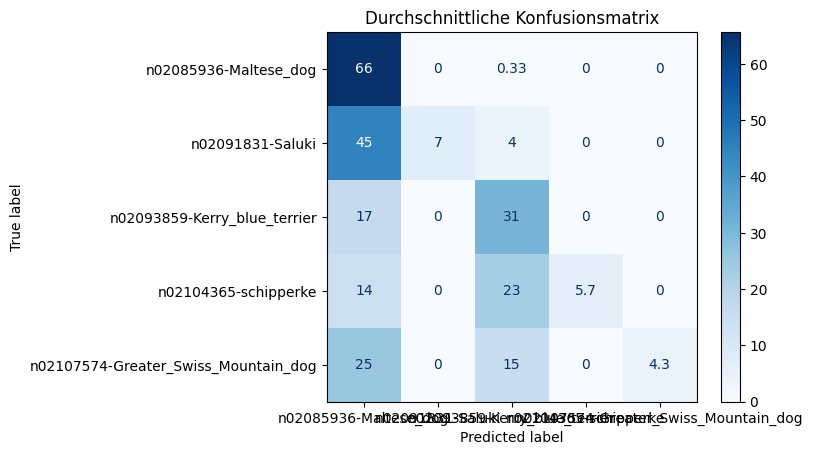

In [17]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical


# Kreuzvalidierung (3-fold)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold = 1
conf_matrices = []

for train_idx, val_idx in kf.split(X_train_img):
    print(f"Fold {fold}:")
    X_train_fold, X_val_fold = np.array(X_train_img)[train_idx], np.array(X_train_img)[val_idx]
    y_train_fold, y_val_fold = np.array(y_train)[train_idx], np.array(y_train)[val_idx]
    
    # Konvertierung der Labels in One-Hot-Encoding
    y_train_fold_cat = to_categorical(y_train_fold, 5)
    y_val_fold_cat = to_categorical(y_val_fold, 5)
    
    # Training
    model.fit(X_train_fold, y_train_fold_cat, validation_data=(X_val_fold, y_val_fold_cat),
              epochs=10, batch_size=32, verbose=1)
    
    # Evaluation
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    conf_matrices.append(confusion_matrix(y_val_fold, y_pred_classes))
    fold += 1

# Mittelwert der Konfusionsmatrizen berechnen
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Visualisierung der Konfusionsmatrix
disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_matrix, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Durchschnittliche Konfusionsmatrix")
plt.show()
